### Build text classification models using TensorFlow with TF-IDF vectorization

We have trained classification models using Scikit Learn and PyTorch, by applying TfidfVectorizer to extract input features. Here we will take the same approach to apply TfidfVectorizer so we can compare the performace among the three different frameworks and libraries.

- Load data into pandas dataframe
- Encode categorical label values into integer type
- Split data into train and test subset using 80/20 ratio
- Use TfidfVectorizer to transform input texts into tfidf encoded float point matrix
- Build and train models
- Evaluate model performace

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import scipy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('bbc-text.csv')
print(df.shape, df['category'].nunique())
df.head(2)

(2225, 2) 5


,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...


In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder().fit(df["category"])
df['encoded_cat'] = le.transform(df['category'])

In [4]:
df.head(2)

,category,text,encoded_cat
0,tech,tv future in the hands of viewers with home th...,4
1,business,worldcom boss left books alone former worldc...,0


#### Split data into train and test dataset

In [5]:
x_train, x_test, y_train, y_test = train_test_split(
    df['text'], df['encoded_cat'], test_size=.2, stratify=df['category'], random_state=42)

In [6]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1780,), (445,), (1780,), (445,))

#### Apply TF-IDF to extract features out of text

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

# Learn vocabulary from training texts and vectorize training texts.
x_train = vectorizer.fit_transform(x_train)

# Vectorize validation texts.
x_test = vectorizer.transform(x_test)

Because TfidfVectorizer returns sparse matrix for efficient memory storage, we need to convert it to normal dense matrix before feed to the neural network

In [8]:
x_train = scipy.sparse.csr_matrix.todense(x_train)
x_test = scipy.sparse.csr_matrix.todense(x_test)

In [9]:
x_train.shape, x_train.reshape(-1, 1).shape

((1780, 26795), (47695100, 1))

#### Construct a 3 layer neural network
I have tried several network stuctures and I found th following structure performs very well, The last layer uses softmax activation function for multiple outputs

In [48]:
model = tf.keras.Sequential([
                            tf.keras.layers.Dense(128, activation='relu', input_shape=(x_train.shape[1],)),
                            tf.keras.layers.Dropout(0.2),
                            tf.keras.layers.Dense(32, activation='relu'),
                            tf.keras.layers.Dropout(0.2),
                            tf.keras.layers.Dense(df['category'].nunique(), activation='softmax')
])

In [49]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 128)               3429888   
_________________________________________________________________
dropout_26 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_27 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 5)                 165       
Total params: 3,434,181
Trainable params: 3,434,181
Non-trainable params: 0
_________________________________________________________________


In [50]:
%%time
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), verbose=2)

Epoch 1/10
56/56 - 1s - loss: 1.2411 - accuracy: 0.7073 - val_loss: 0.6162 - val_accuracy: 0.9618
Epoch 2/10
56/56 - 1s - loss: 0.3010 - accuracy: 0.9775 - val_loss: 0.1418 - val_accuracy: 0.9753
Epoch 3/10
56/56 - 1s - loss: 0.0644 - accuracy: 0.9961 - val_loss: 0.0880 - val_accuracy: 0.9775
Epoch 4/10
56/56 - 1s - loss: 0.0287 - accuracy: 0.9989 - val_loss: 0.0698 - val_accuracy: 0.9775
Epoch 5/10
56/56 - 1s - loss: 0.0148 - accuracy: 0.9994 - val_loss: 0.0687 - val_accuracy: 0.9775
Epoch 6/10
56/56 - 1s - loss: 0.0111 - accuracy: 1.0000 - val_loss: 0.0647 - val_accuracy: 0.9775
Epoch 7/10
56/56 - 1s - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.0643 - val_accuracy: 0.9775
Epoch 8/10
56/56 - 1s - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0629 - val_accuracy: 0.9843
Epoch 9/10
56/56 - 1s - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0625 - val_accuracy: 0.9843
Epoch 10/10
56/56 - 1s - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0616 - val_accuracy: 0.9843
CPU times: user 1mi

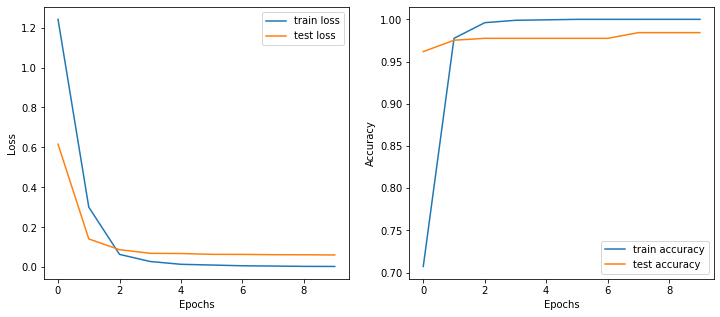

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']);
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['train loss', 'test loss']);
ax = plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['train accuracy', 'test accuracy']);


Using TF-IDF vectorized input data to feed into a two hidden layer network, and applying dropout at each hidden layer to prevent overfitting, we can achieve 98.4% test accuracy in just 8 epochs. It only took 10 seconds to run though all 10 epochs.